<a href="https://colab.research.google.com/github/ayushi-gajendra/SkinShots_AI_powered_skincare_platform/blob/tensorflow-model/Model_for_SkinShots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model for our SkinShots Website**
We are creating a **Multiclass Classification** Neural Network Model for our SkinShots project.

### **Key Concepts & Steps Covered:**

1. **Understanding the Data**

* We are starting with our **Skin** dataset.
* We define **features and labels**.
* We inspect it (shape, number of classes, etc.).

2. **Preprocessing**

* We **scale/normalize** data, if needed.
* We possibly **encode categorical labels**.
* We split it into **training, validation, test** sets.

3. **Building the Model**

* We define a neural network architecture using **tf.keras.Sequential** .
* Layers usually include **input** layer (or specifying input shape), **hidden** layers (Dense, with activation like ReLU), and **output** layer (with activation appropriate for classification, softmax for multi-class).

4. **Compile the Model**

* We specify **loss** function (e.g. sparse_categorical_crossentropy or binary_crossentropy depending on setup).
* Specify **optimizer** (e.g. Adam).
* **Metrics** (like accuracy) to monitor.

5. **Training**

* **Fit** the model on **training data.**
* We use **validation data** to see how well the model is generalizing.
* We use **callbacks** or track **history.**

6. **Evaluation**

* Evaluate on **test data** to see final performance.
* Check metrics, possibly **confusion matrix** or other **classification metrics**.

7. **Prediction**

* Use the model to **predict new/unseen data.**
* We possibly inspect **how certain it is** (softmax probabilities, etc.).



---



## 1. **Understanding the Data**

* The data is in our **Skin** Directory - with 5 subfolders representing **5 classes**
* The 5 classes are - **Acne, Blackheads, Dark Spots, Pores, Wrinkles**



---


## 2. **Preprocessing the Data**

* We will first split the data into - **Training, Validation** and **Test** sets



In [5]:
import tensorflow as tf

# Getting the Training data (70%)

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Skin",
    image_size=(256,256),
    batch_size=32,
    label_mode="categorical",
    validation_split=0.3,
    subset="training",
    seed=42)

Found 8182 files belonging to 5 classes.
Using 5728 files for training.


* `validation_split`: Fraction of data to reserve for validation.

* * Example: validation_split=0.3 → 30% of images go to validation, 70% to training.

* `subset`: Either "training" or "validation".

* * "training" → takes the (1 - validation_split) fraction

* * "validation" → takes the validation_split fraction

* We provide a `seed` to ensure the split is deterministic. Otherwise, training and validation sets may overlap randomly.

In [7]:
# Getting Validation and Testing data

temp_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Skin",
    image_size=(256,256),
    batch_size=32,
    label_mode="categorical",
    validation_split=0.3,
    subset="validation",
    seed=42
)

# Splitting temp validation data (30%) into Validation (15%) and Testing (15%) data

total_batches = tf.data.experimental.cardinality(temp_ds).numpy()
temp_batches = int(0.5 * total_batches)
val_ds = temp_ds.take(temp_batches)
test_ds = temp_ds.skip(temp_batches)

val_ds, test_ds

Found 8182 files belonging to 5 classes.
Using 2454 files for validation.


(<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 <_SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>)

* 🔹 **Syntax:** `tf.data.experimental.cardinality(dataset)`

* 🔹 **Parameters:** dataset: a `tf.data.Dataset` object.

* 🔹 **Returns:** A scalar `tf.Tensor` with the number of elements (batches).

* When you use **image_dataset_from_directory()** (or other dataset creation functions), you get a **tf.data.Dataset** object.

* A tf.data.Dataset is an **iterator-like pipeline**, not a static list. So you can’t just call len(dataset).

* To know **how many elements (batches)** are inside a dataset, TensorFlow provides the **tf.data.experimental.cardinality() function**.

* **Cardinality** means “number of elements.”

* Here, **each element** = **1 batch** (not individual images).

* The result is a **tf.Tensor** containing the **count**.

* **.numpy()** converts that tensor to a Python integer.


* **take()** and **skip()** are functional dataset transformations → they let us **slice datasets** into **non-overlapping subsets**.
* 🔹 **Syntax:**

* * ` dataset.take(n)` → first n batches : this becomes the validation set


* * ` dataset.skip(n)` → everything after the first n batches : this becomes the testing set

## **Further understanding the data**



In [44]:
# Chceking out the training dataset
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

### 1a. ***Features & Labels***

* Each **dataset** element is a **tuple**: (images, labels)
* * TensorFlow’s image_dataset_from_directory always returns a tuple:

**Features** (X): The **input data** we feed into our model.
* In an image classification problem, the **image pixels** are the **features**.

* Data type → tf.float32 (pixel values, usually scaled 0–255 or normalized to 0–1)


**Labels** (y): The **target/output** the model is trying to predict.

* In our project → the **skin condition class** (Acne, Blackheads, Dark Spots, Pores, Wrinkles).

* Because we used label_mode = "categorical", **labels are one-hot encoded vectors**.


Why it shows `None` instead of our batch size?

The **dataset object** (tf.data.Dataset) is abstract, it doesn’t know the batch size at the metadata level.

None means **“variable dimension”** — TensorFlow is leaving it flexible, because the last batch might not always be exactly 32.

Example: if our dataset had 5728 images, dividing by 32 gives 179.0 batches exactly.

If it were 5730 images, the last batch would only have 2 images.

**So TensorFlow shows None to indicate “batch dimension depends on runtime”.**

### 1b. ***Inspect the dataset***

In [42]:
# Checking number of classes and names

class_names = train_ds.class_names
print("Class Name:", class_names)
print("Number of classes:", len(class_names))

Class Name: ['acne', 'blackheades', 'dark spots', 'pores', 'wrinkles']
Number of classes: 5


`image_dataset_from_directory()` automatically **assigns class names** based on **folder names.**

Our dataset folders are Acne/, Blackheads/, DarkSpots/, … so class_names = ['Acne', 'Blackheads', 'DarkSpots', 'Pores', 'Wrinkles']

In [43]:
# Check the shapes of one batch

for images, labels in train_ds.take(1):
  print("Image batch shape:", images.shape)
  print("Label batch shape:", labels.shape)

Image batch shape: (32, 256, 256, 3)
Label batch shape: (32, 5)


* A `tf.data.Dataset object (train_ds)` doesn’t directly store all data in memory. Instead, we iterate over it in batches.

* `train_ds.take(1)` → takes the first batch from the dataset.

* `images` → tensor containing a batch of images.

* `labels` → tensor containing one-hot encoded labels.

* `Shape` tells us how images are arranged in the batch.

* * **Features** (X) - Images:

* * Shape: `(batch_size, height, width, channels)`

* * * (32, 256, 256, 3) → 32 RGB images, each 256×256.

* * * 32 → batch size = 32 images.

* * * 256, 256 → height and width of each image.

* * * 3 → RGB color channels.


* * **Labels** (y):

* * Shape: `(batch_size, num_classes)`

* * * (32, 5) → 32 labels, each a vector like [0,0,1,0,0] (meaning "Dark Spots").

* * * Shape of the labels depends on label_mode:

* * * * If label_mode="int" → (32,) (each label is an integer class index).

* * * * If label_mode="categorical" → (32, num_classes) (each label is a one-hot vector).

In [38]:
# Checking the first image & label

first_image = images[0].numpy().astype("uint8")
first_label = labels[0].numpy()
print("First image:", first_image)
print("first_label", first_label)

First image: [[[8 8 8]
  [8 8 8]
  [8 8 8]
  ...
  [8 8 8]
  [8 8 8]
  [8 8 8]]

 [[8 8 8]
  [8 8 8]
  [8 8 8]
  ...
  [8 8 8]
  [8 8 8]
  [8 8 8]]

 [[8 8 8]
  [8 8 8]
  [8 8 8]
  ...
  [8 8 8]
  [8 8 8]
  [8 8 8]]

 ...

 [[8 8 8]
  [8 8 8]
  [8 8 8]
  ...
  [8 8 8]
  [8 8 8]
  [8 8 8]]

 [[8 8 8]
  [8 8 8]
  [8 8 8]
  ...
  [8 8 8]
  [8 8 8]
  [8 8 8]]

 [[8 8 8]
  [8 8 8]
  [8 8 8]
  ...
  [8 8 8]
  [8 8 8]
  [8 8 8]]]
first_label [0. 0. 0. 1. 0.]


`images[0]` → picks the **first image** from the **current batch**.

`.numpy()` → converts it from a **TensorFlow tensor** into a **NumPy array** (so **matplotlib can use it**).

`.astype("uint8")` → **casts** the values **into integers between 0–255** (standard pixel format).

Class name: pores
None


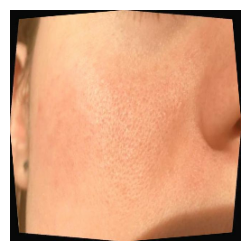

In [39]:
# Visualising the first image

import matplotlib.pyplot as plt

plt.figure(figsize=(3,3))
plt.imshow(first_image)
plt.axis("off")
class_index= first_label.argmax()
print(print("Class name:", class_names[class_index]))

`plt.figure(figsize=(3,3))` → creates a plotting canvas of size 3×3 inches.

`plt.imshow(first_image)` → displays the image from pixel values. imshow expects a NumPy array (2D for grayscale, 3D for RGB)

`plt.axis("off")` → hides the axis ticks/labels (so it looks like a clean picture).

`class_index = first_label.argmax()` → gets the index of the highest value in the label vector (the actual class number).

## 3. **Building the model**

## 4. **Comipling the model**


## 5. **Training the model**

In [11]:
# Creating the model - CNN model

model = tf.keras.Sequential([

    # 1st convulation + pooling
    tf.keras.layers.Conv2D(filters=30, kernel_size=(3,3), activation="relu", input_shape=(256,256,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    # 2nd convulation + pooling
    tf.keras.layers.Conv2D(filters=60, kernel_size=(3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten feature maps → Dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation="relu"),
    tf.keras.layers.Dense(5, activation="softmax")
])

# Compiling the model
model.compile(loss = tf.keras.losses.CategoricalCrossentropy,
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Training/fitting the model
model.fit(train_ds, validation_data= val_ds, epochs=5)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 1323s 7s/step - accuracy: 0.4556 - loss: 300.3724 - val_accuracy: 0.6850 - val_loss: 0.8957
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 53s 294ms/step - accuracy: 0.7715 - loss: 0.6624 - val_accuracy: 0.7122 - val_loss: 0.8540
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 216ms/step - accuracy: 0.8531 - loss: 0.4573 - val_accuracy: 0.7377 - val_loss: 1.1055
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 192ms/step - accuracy: 0.9113 - loss: 0.3066 - val_accuracy: 0.7590 - val_loss: 0.9844
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 32s 181ms/step - accuracy: 0.9421 - loss: 0.1946 - val_accuracy: 0.7500 - val_loss: 1.3506


### **Why we choose a CNN model for images**

* **Images** are not just random numbers — they have **spatial structure**(neighboring pixels form edges, textures, patterns).

* A normal **Dense** neural net:
* * Would need millions of parameters to handle a 256×256×3 image.
* * Ignores pixel positions (treats them all the same).

* **CNNs** are **designed to handle images** because they:

* * Look at small regions at a time (**local patterns**).

* * Reuse filters across the whole image (**fewer parameters**).

* * Build up from **edges → textures → shapes → objects**.

### **Why we use each part of a CNN model**

1. **Input Layer**

* Why we need it:
* * The image comes in as (256, 256, 3) (height, width, RGB channels).

* Why not flatten immediately?
* * If we flatten right away, we lose the spatial relationships (neighboring pixels that form edges/spots).

2. **Convolutional Layers (Conv2D)**

* Why:
* * Instead of learning weights for every pixel separately, Conv2D uses filters/kernels that slide across the image, learning local patterns (edges, pores, spots).

* * Looks at small patches of the image (like 3×3 pixels).

* Why not Dense from the start?
* * Dense layers treat each pixel independently → too many parameters (millions!) and no sense of location.

* Benefit: Much fewer parameters, captures spatial features.

3. **Activation Function (ReLU)**

* Why:
* * Without non-linearity, the network is basically just doing linear transformations.

* * ReLU (f(x)=max(0,x)) is simple and prevents vanishing gradients (a common training problem).

* * Just turns all negative numbers into 0. This helps the network learn faster and not get stuck.

* Why not Sigmoid/Tanh?
* * They squish values into small ranges, making deep networks hard to train.
* * ReLU is faster and works better for images.

4. **Pooling Layers (MaxPooling2D)**

* Why:
* * Images are huge, and we don’t need every pixel.
* * Pooling reduces size while keeping the most important info (like “was there a spot in this region?”).

* * Shrinks the image while keeping the most important part.

* * Example: instead of remembering every pixel of a spot, it just remembers “there was a strong spot here”.

* Why MaxPooling and not AveragePooling?

* * MaxPooling keeps the strongest signal (the most activated feature). AveragePooling can blur/lose sharp features.

* Benefit: Smaller feature maps → fewer computations, more robust to small shifts (if a spot moves slightly, the model still detects it).

5. **Flatten**

* Why:
* * After convolution + pooling, we have a 3D feature map (height × width × channels).

* * Flatten converts it into a 1D vector so we can feed it into Dense layers.

* Why not keep it 3D? Dense layers only work with 1D input.

6. **Dense (Fully Connected) Layers**

* Why:
* * These layers combine all extracted features and “decide” what class the image belongs to.

* * Think of them as the classifier that sits on top of the feature extractor.

* * Think of this part as the decision maker: “based on these features, is it acne, pores, or wrinkles?”

* Why not only Conv layers?
* * Conv layers are great at feature extraction, but Dense layers are good at combining them for final decisions.

7. **Output Layer (Dense with Softmax)**

* Why Softmax?
* * Converts the raw numbers (logits) into probabilities across your 5 classes.

* * Ensures they add up to 1, so you can interpret it as: “70% Acne, 20% Dark Spot, 10% Pores”.

* Why not Sigmoid?
* * Sigmoid is for binary classification (yes/no).
* * For multiclass, we need Softmax.

**Dropout (optional, but often used)**

Why: Prevents overfitting by randomly turning off some neurons during training.

This forces the model to learn robust patterns, not memorize the training set.

Why not always? Too much dropout = underfitting.


✅ **So in simple terms:**

* Conv2D = feature finder (edges, spots).

* ReLU = makes learning faster.

* Pooling = keeps only important stuff.

* Flatten + Dense = final decision making.

* Dropout = avoids overfitting.

* Softmax = gives probabilities for each class.

CNN is chosen because **it’s built for image data.**

Inside CNN: each part **(Conv → ReLU → Pool → Dense → Softmax)** plays a role in extracting features, simplifying them, and finally making a classification.

## 6. **Evaluating the model & Improving the model**

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 30)   │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 30)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 60)   │        16,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 230640)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │    27,676,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           605 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,083,877 (316.94 MB)

 Trainable params: 27,694,625 (105.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 55,389,252 (211.29 MB)

In [13]:
model.evaluate(test_ds)

39/39 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - accuracy: 0.7773 - loss: 1.1285


[1.1916389465332031, 0.7665589451789856]

In [1]:
# Improving the model by increasing Epochs and adding an Early stopping

model_2 = tf.keras.Sequential([

    # 1st convulation + pooling
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(256,256,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    # 2nd convulation + pooling
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten feature maps → Dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(5, activation="softmax")
])

# Compiling the model
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy,
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Training/fitting the model
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)
history = model_2.fit(train_ds, validation_data= val_ds, epochs=20)

NameError: name 'tf' is not defined

In [ ]:
model_2.summary()

In [ ]:
model_2.evaluate(test_ds)